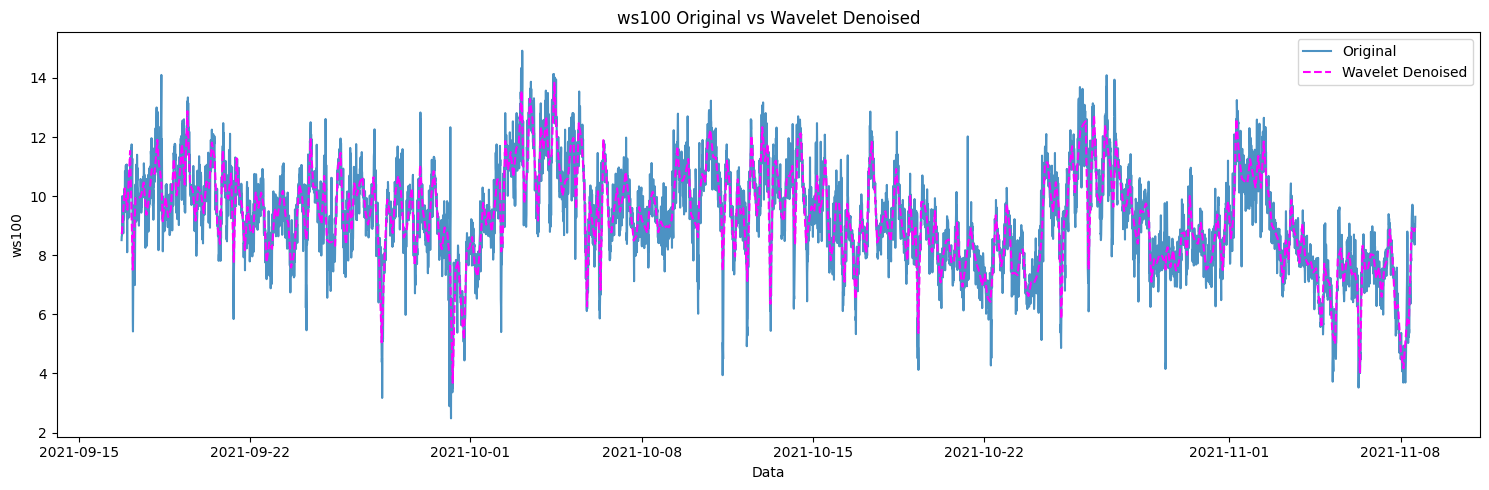

Matriz de Correlação entre os Componentes de Tendência:
                     ws100_wavelet  humid_wavelet  wdisp100_wavelet  \
ws100_wavelet             1.000000      -0.450274          0.676428   
humid_wavelet            -0.450274       1.000000         -0.719829   
wdisp100_wavelet          0.676428      -0.719829          1.000000   
temp_wavelet              0.275961      -0.904013          0.616083   
vertdisp100_wavelet       0.428749      -0.856791          0.851956   

                     temp_wavelet  vertdisp100_wavelet  
ws100_wavelet            0.275961             0.428749  
humid_wavelet           -0.904013            -0.856791  
wdisp100_wavelet         0.616083             0.851956  
temp_wavelet             1.000000             0.869147  
vertdisp100_wavelet      0.869147             1.000000  


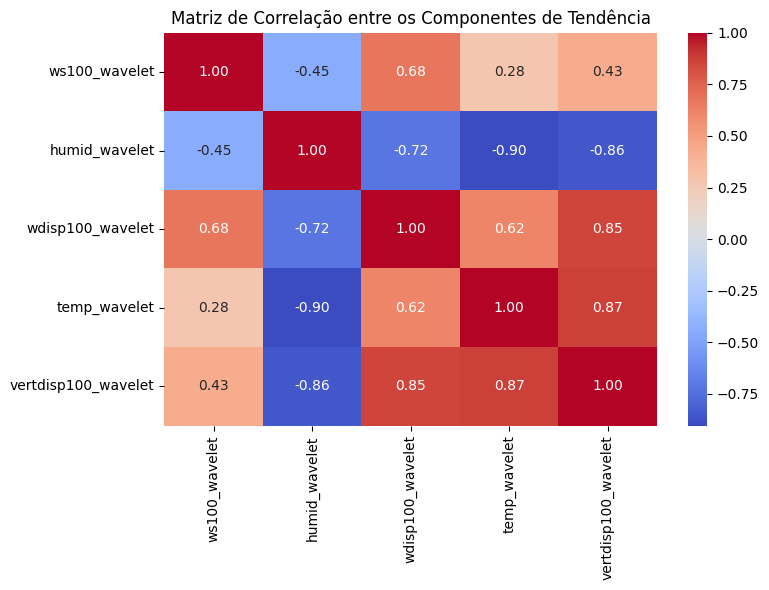

Forma dos dados escalados: (7561, 5)
Forma de X: (7472, 72, 5)
Forma de y: (7472, 18)
Treino X: (5977, 72, 5), Treino y: (5977, 18)
Teste X: (1495, 72, 5), Teste y: (1495, 18)
Valor calculado de delta (80th percentile): 0.1858479190652741
Decoder Input Treino: (5977, 18, 5)
Decoder Target Treino: (5977, 18)
Decoder Input Teste: (1495, 18, 5)
Decoder Target Teste: (1495, 18)

Iniciando o treinamento da execução 1/1
Epoch 1/200


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_inputs', 'decoder_inputs']. Received: the structure of inputs=('*', '*')
  warnings.warn(


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0473 - mae: 0.3310 - val_loss: 0.0064 - val_mae: 0.0923 - learning_rate: 1.0000e-04
Epoch 2/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0042 - mae: 0.0714 - val_loss: 0.0029 - val_mae: 0.0566 - learning_rate: 1.0000e-04
Epoch 3/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0025 - mae: 0.0531 - val_loss: 0.0019 - val_mae: 0.0435 - learning_rate: 1.0000e-04
Epoch 4/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0019 - mae: 0.0452 - val_loss: 0.0016 - val_mae: 0.0417 - learning_rate: 1.0000e-04
Epoch 5/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0015 - mae: 0.0391 - val_loss: 0.0013 - val_mae: 0.0353 - learning_rate: 1.0000e-04
Epoch 6/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0012 - mae: 0.0344 - val_loss: 0.0012 - val_mae: 0.0353 - learning_rate: 1.0000e-04
Epoch 7/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0010 - mae: 0.0310 - val_loss: 9.6171e-04 - val_mae: 0.0308 

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import Huber

# 1. Carregamento e Pré-processamento dos Dados
data = pd.read_csv("dataset.csv")

# Verificar se a coluna 'id' existe
if 'id' not in data.columns:
    raise ValueError("A coluna 'id' não existe no dataset.")

# Converter a coluna 'id' para datetime
data['id_str'] = data['id'].astype(str).apply(lambda x: x.split('.')[0])  # Remove a parte decimal, se existir
data['id_datetime'] = pd.to_datetime(data['id_str'], errors='coerce')  # Converte para datetime, valores inválidos serão NaT

# Verificar se a conversão foi bem-sucedida
if data['id_datetime'].isnull().any():
    raise ValueError("Algumas entradas na coluna 'id' não puderam ser convertidas para datetime.")

# Definir o índice como a coluna de datetime
data.set_index('id_datetime', inplace=True)

# Remover colunas auxiliares se necessário
data.drop(columns=['id_str'], inplace=True)

# Aplicar denoising com wavelet
variables = pd.DataFrame(index=data.index)

def wavelet_denoising(signal, wavelet='bior2.2', level=4):
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='symmetric')
    return reconstructed_signal[:len(signal)]

columns_to_denoise = ['ws100', 'humid', 'wdisp100', 'temp', 'vertdisp100']

for col in columns_to_denoise:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal  
    else:
        raise ValueError(f"A coluna '{col}' não existe no dataset.")

# Plotar ws100 original vs denoised
plt.figure(figsize=(15, 5))
plt.plot(data.index, data['ws100'], label='Original', alpha=0.8)
plt.plot(variables.index, variables['ws100_wavelet'], label='Wavelet Denoised', linestyle='--', color='magenta')
plt.title('ws100 Original vs Wavelet Denoised')
plt.xlabel('Data')
plt.ylabel('ws100')
plt.legend()
plt.tight_layout()
plt.show()

# Calcular a matriz de correlação
correlation_matrix = variables.corr()

print("Matriz de Correlação entre os Componentes de Tendência:")
print(correlation_matrix)

# Plotar a matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre os Componentes de Tendência')
plt.tight_layout()
plt.show()

# Normalização dos Dados
scaler_ws100 = MinMaxScaler()
scaler_other = MinMaxScaler()

if 'ws100_wavelet' not in variables.columns:
    raise ValueError("A coluna 'ws100_wavelet' não foi encontrada no DataFrame 'variables'.")

variables_scaled_ws100 = scaler_ws100.fit_transform(variables[['ws100_wavelet']])
variables_other = variables.drop(columns=['ws100_wavelet'])
variables_scaled_other = scaler_other.fit_transform(variables_other)
scaled_columns = ['ws100_wavelet'] + list(variables_other.columns)
variables_scaled = pd.DataFrame(
    np.hstack((variables_scaled_ws100, variables_scaled_other)),
    columns=scaled_columns,
    index=variables.index
)

print(f"Forma dos dados escalados: {variables_scaled.shape}")


In [ ]:

# 2. Criação de Sequências para o Modelo Seq2Seq
input_steps = 72
output_steps = 18

def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps)])
        y.append(data[(i + input_steps):(i + input_steps + output_steps), 0])  # 'ws100_wavelet' é a primeira coluna
    return np.array(X), np.array(y)

data_array = variables_scaled.values

X, y = create_sequences(data_array, input_steps, output_steps)

print(f"Forma de X: {X.shape}")  # [samples, input_steps, num_features]
print(f"Forma de y: {y.shape}")  # [samples, output_steps]

# Dividir em treino e teste
split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Treino X: {X_train.shape}, Treino y: {y_train.shape}")
print(f"Teste X: {X_test.shape}, Teste y: {y_test.shape}")


In [ ]:

# 3. Definição da Função de Perda Huber do Keras
ws100_values = variables_scaled_ws100.flatten()
abs_deviation = np.abs(ws100_values - np.mean(ws100_values))
delta = np.percentile(abs_deviation, 80)
print(f"Valor calculado de delta (80th percentile): {delta}")

# Alternativamente, usar a função de perda Huber do Keras com reduction padrão
huber_loss = Huber(delta=delta)  # 'sum_over_batch_size' é o padrão

num_features = X_train.shape[2]


In [ ]:
# 4. Construção do Modelo Seq2Seq
def build_simple_seq2seq(input_steps, num_features, output_steps):
    units = 64
    optimizer = Adam(learning_rate=1e-4)
    
    # Encoder
    encoder_inputs = Input(shape=(input_steps, num_features), name='encoder_inputs')
    encoder_lstm = LSTM(units, return_sequences=True, return_state=True, 
                        kernel_regularizer=l2(1e-5), name='encoder_lstm')
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
    
    # Decoder
    decoder_inputs = Input(shape=(output_steps, num_features), name='decoder_inputs')
    decoder_lstm = LSTM(units, return_sequences=True, return_state=True, 
                        kernel_regularizer=l2(1e-5), name='decoder_lstm')
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    
    # Atenção Simples
    attention = Attention(name='attention_layer')
    attention_output = attention([decoder_outputs, encoder_outputs])
    
    # Concatenar a saída da atenção com as saídas do decoder
    decoder_combined = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_output])
    
    # Camada de Saída
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined)
    outputs = Reshape((output_steps,))(outputs)
    
    # Definição do Modelo
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs, 
                  name='Simple_Seq2Seq_Model')
    
    # Definir a função de perda Huber do Keras
    model.compile(optimizer=optimizer,
                  loss=huber_loss,  # Utilize a função de perda corrigida
                  metrics=['mae'])
    
    return model


In [ ]:

# 5. Preparação das Entradas do Decoder
def prepare_decoder_inputs_targets(y_train, y_test, num_features):
    """
    Prepara as entradas do decoder deslocando os targets e adicionando um token de início.
    
    Args:
        y_train (np.array): Targets de treinamento com forma (samples, output_steps)
        y_test (np.array): Targets de teste com forma (samples, output_steps)
        num_features (int): Número de features (para a dimensão adicional)
    
    Returns:
        decoder_input_train (np.array): Entradas do decoder para treinamento com forma (samples, output_steps, num_features)
        decoder_target_train (np.array): Targets do decoder para treinamento com forma (samples, output_steps)
        decoder_input_test (np.array): Entradas do decoder para teste com forma (samples, output_steps, num_features)
        decoder_target_test (np.array): Targets do decoder para teste com forma (samples, output_steps)
    """
    # Inicializar decoder inputs com zeros
    decoder_input_train = np.zeros((y_train.shape[0], y_train.shape[1], num_features))
    decoder_input_test = np.zeros((y_test.shape[0], y_test.shape[1], num_features))
    
    # Preencher o decoder_input_train com y_train deslocado para a direita na primeira feature
    decoder_input_train[:, 1:, 0] = y_train[:, :-1]
    decoder_input_test[:, 1:, 0] = y_test[:, :-1]
    
    # Definir o primeiro passo como um token de início (e.g., 0)
    decoder_input_train[:, 0, 0] = 0
    decoder_input_test[:, 0, 0] = 0
    
    # Targets permanecem como y_train e y_test
    decoder_target_train = y_train
    decoder_target_test = y_test
    
    return decoder_input_train, decoder_target_train, decoder_input_test, decoder_target_test

decoder_input_train, decoder_target_train, decoder_input_test, decoder_target_test = prepare_decoder_inputs_targets(
    y_train, y_test, num_features
)

print(f"Decoder Input Treino: {decoder_input_train.shape}")    # (samples, output_steps, num_features)
print(f"Decoder Target Treino: {decoder_target_train.shape}")  # (samples, output_steps)
print(f"Decoder Input Teste: {decoder_input_test.shape}")      # (samples, output_steps, num_features)
print(f"Decoder Target Teste: {decoder_target_test.shape}")    # (samples, output_steps)


In [ ]:

# 6. Treinamento do Modelo
num_runs = 1
best_val_loss = float('inf')
best_model_path = 'best_model.h5.keras'

for run in range(1, num_runs + 1):
    print(f"\nIniciando o treinamento da execução {run}/{num_runs}")
    
    # Construir o modelo para cada execução
    model = build_simple_seq2seq(input_steps, num_features, output_steps)
    
    temp_checkpoint = f'best_model_run{run}.h5.keras'
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(temp_checkpoint, monitor='val_loss', save_best_only=True, save_weights_only=False)
    ]
    
    history = model.fit(
        [X_train, decoder_input_train], decoder_target_train, 
        epochs=200,  
        batch_size=32, 
        validation_data=([X_test, decoder_input_test], decoder_target_test),
        callbacks=callbacks,
        verbose=1
    )
    
    run_best_val_loss = min(history.history['val_loss'])
    print(f"Melhor val_loss na execução {run}: {run_best_val_loss}")
    
    if run_best_val_loss < best_val_loss:
        print(f"A execução {run} melhorou o val_loss global. Salvando o modelo como o melhor.")
        best_val_loss = run_best_val_loss
        shutil.copyfile(temp_checkpoint, best_model_path)
    else:
        print(f"A execução {run} não melhorou o val_loss global.")
    
    # Remover o checkpoint temporário para economizar espaço
    os.remove(temp_checkpoint)

print(f"\nTreinamento completo. Melhor val_loss alcançado: {best_val_loss}")


Modelo carregado com sucesso.
 1/47 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step

/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['encoder_inputs', 'decoder_inputs']. Received: the structure of inputs=('*', '*')
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Previsões realizadas com sucesso.


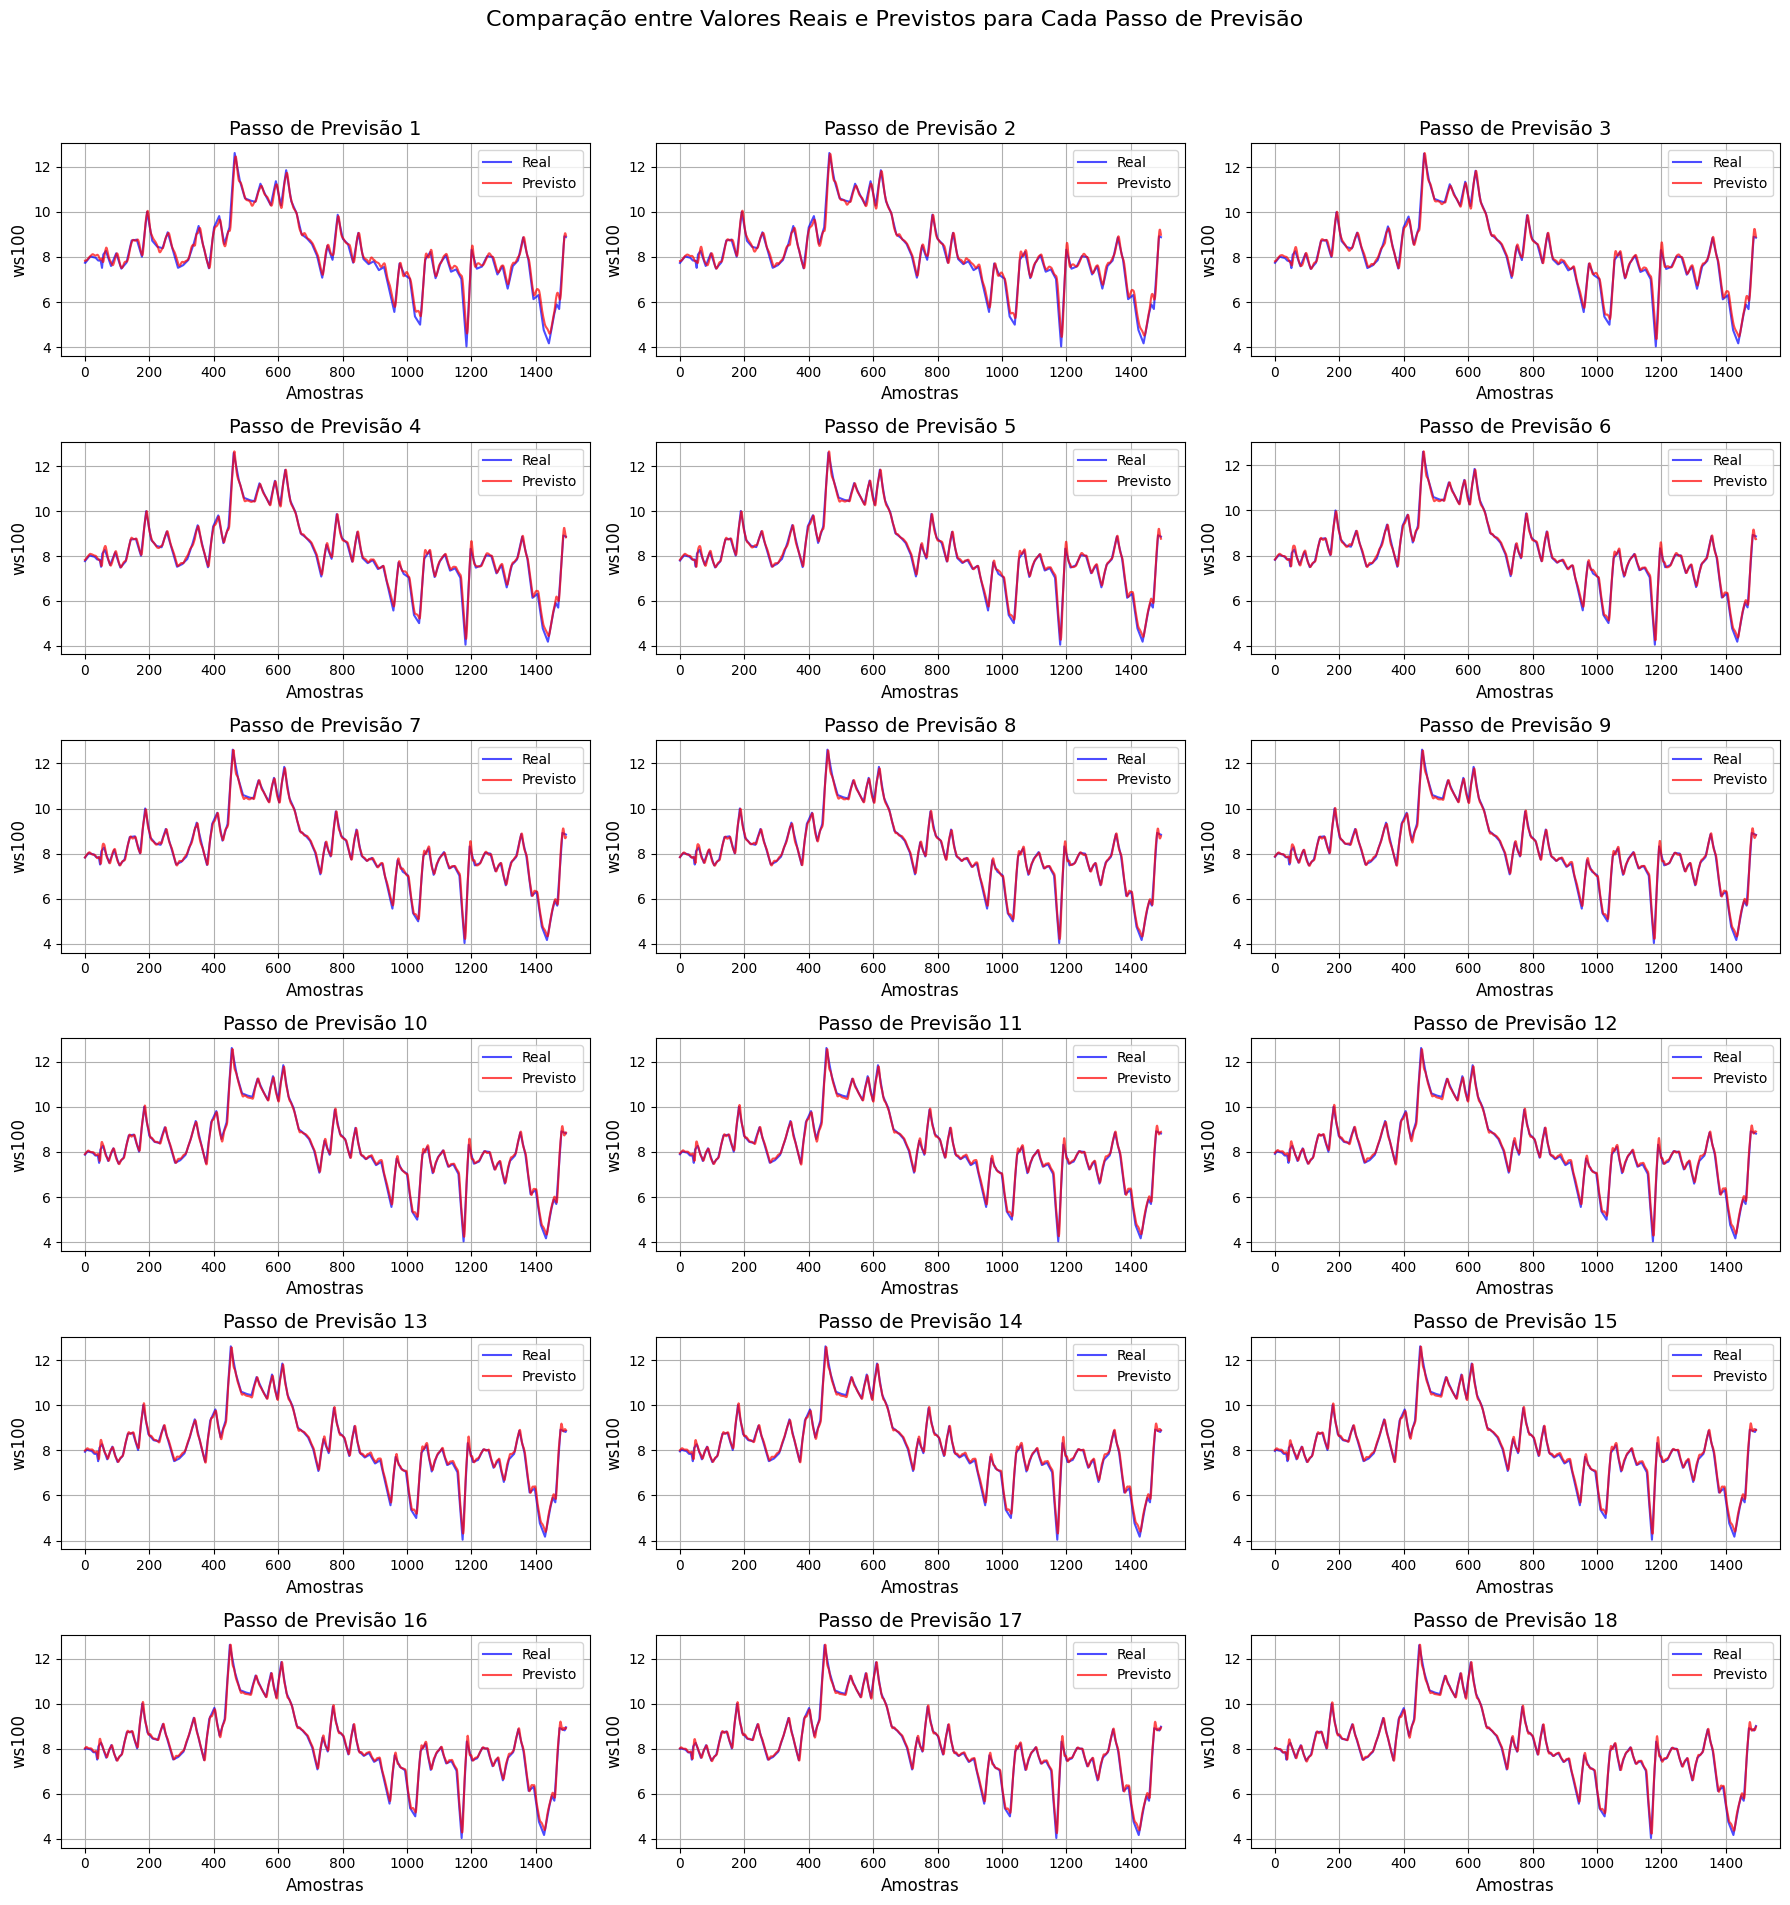

In [34]:
from tensorflow.keras.models import Model, load_model

# Carregar o modelo completo
best_model = load_model(best_model_path, custom_objects={'Huber': Huber})
print("Modelo carregado com sucesso.")

# Verificar se decoder_input_test está preparado
if 'decoder_input_test' not in locals():
    raise ValueError("A variável 'decoder_input_test' não está definida. Certifique-se de prepará-la antes da inferência.")

# Fazer previsões passando ambos os inputs
try:
    y_pred = best_model.predict([X_test, decoder_input_test])
    print("Previsões realizadas com sucesso.")
except Exception as e:
    print(f"Erro ao fazer previsões: {e}")
    raise

# Inversamente escalar as previsões e os valores reais
# Reshape para aplicar inverse_transform
y_pred_reshaped = y_pred.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Inversamente escalar
y_pred_inversed = scaler_ws100.inverse_transform(y_pred_reshaped).reshape(y_pred.shape)
y_test_inversed = scaler_ws100.inverse_transform(y_test_reshaped).reshape(y_test.shape)

# Plotar as previsões vs valores reais
output_steps = 18

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.suptitle('Comparação entre Valores Reais e Previstos para Cada Passo de Previsão', fontsize=16)

for step in range(output_steps):
    row = step // 3
    col = step % 3
    ax = axes[row, col]
    
    real = y_test_inversed[:, step]
    pred = y_pred_inversed[:, step]
    
    ax.plot(real, label='Real', color='blue', alpha=0.7)
    ax.plot(pred, label='Previsto', color='red', alpha=0.7)
    
    ax.set_title(f'Passo de Previsão {step + 1}', fontsize=14)
    ax.set_xlabel('Amostras', fontsize=12)
    ax.set_ylabel('ws100', fontsize=12)
    ax.legend()
    ax.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()
